In [1]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
from sklearn.metrics import precision_recall_curve
from matplotlib.patches import Rectangle
import statsmodels.api as sm
import matplotlib

In [2]:
#family_id = '11002'
#family_id = '11089'
ped_file = '../../DATA/hg002/hg002.ped'
phase_dir = '../archived_phased/phased_hg002_del_qs'
chroms = [str(x) for x in range(1, 23)]

assembly = '37'

In [3]:
colors=['#ef6c00', '#4db6ac', '#ce93d8ff']
matplotlib.rcParams.update({'font.size': 15})


In [4]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if (fam_id, m_id, f_id) not in fam_to_inds:
                fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
            fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                
print('ped loaded')

ped loaded


# pull our deletions

In [5]:
# pull deletions
deletions = []
with open('%s/deletions.json' % phase_dir) as f:
    for d in json.load(f):
        if d['is_inherited'] and not d['is_hts'] and d['length']>1000:
            for child in d['trans']:
                if d['chrom'] in chroms:
                    deletions.append({
                                    'family': d['family'],
                                    'child': child,
                                    'chrom': d['chrom'],
                                    'start_pos': d['start_pos'],
                                    'end_pos': d['end_pos'],
                                    'length': d['length'],
                                    'opt_start_pos': d['opt_start_pos'],
                                    'opt_end_pos': d['opt_end_pos'],
                                    'is_mat': d['is_mat'],
                                    'is_pat': d['is_pat'],
                                    'mother': d['mother'],
                                    'father': d['father'],
                                    'is_inherited': d['is_inherited'],
                                    'is_denovo': d['is_denovo'],
                                    'quality_score': None if 'quality_score' not in d else d['quality_score']
                            })
print(len(deletions))

93


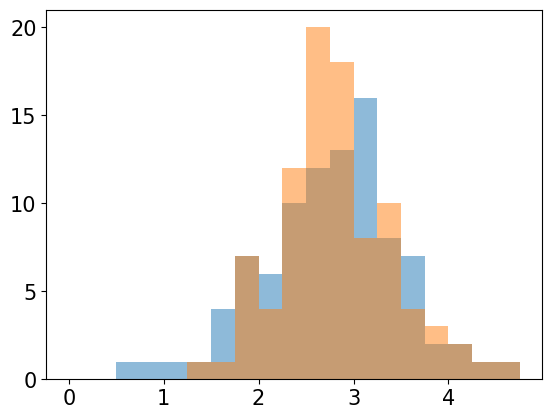

In [6]:
plt.hist(np.log10([d['start_pos']-d['opt_start_pos'] for d in deletions]), alpha=0.5, bins=np.arange(0, 5, 0.25))
plt.hist(np.log10([d['opt_end_pos']-d['end_pos'] for d in deletions]), alpha=0.5, bins=np.arange(0, 5, 0.25))
plt.show()

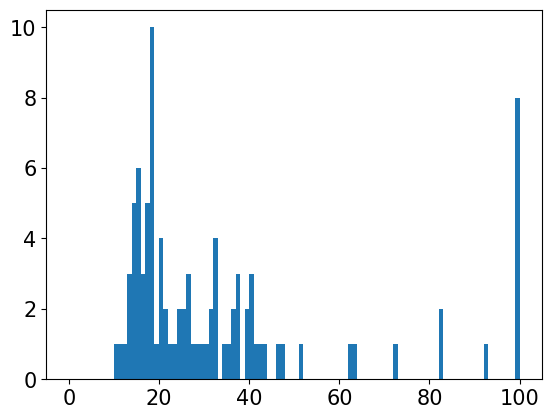

In [7]:
plt.hist(np.clip([d['quality_score'] for d in deletions if d['quality_score'] is not None], None, 100), 
         bins=np.arange(101))
plt.show()

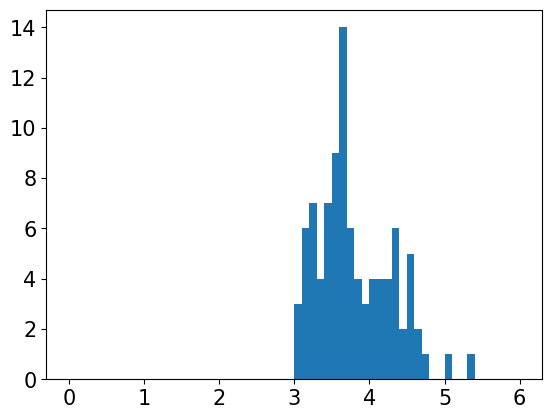

In [8]:
plt.hist(np.clip(np.log10([d['length'] for d in deletions]), 0, 6), 
         bins=np.arange(0, 6.1, 0.1))
plt.show()

# pull ground truth deletions

In [9]:
# pull deletions

bad_gts = set([('0/1', '0/0', '0/0'),
               ('1/1', '0/0', '0/0')])

ground_truth = []
with gzip.open('../data/hg002/HG002_SVs_Tier1_v0.6.vcf.gz', 'rt') as f:
    line = next(f)
    while line.startswith('#'):
        #print(line)
        line = next(f)
        
    for line in f:
        if 'SVTYPE=DEL' in line:
            # is deletion
            pieces = line.strip().split('\t')
            if pieces[0] in chroms:
                gt = pieces[9][:3]
                
                if (gt == '0/1' or gt == '1/1'):# and (pieces[6]=='.' or pieces[6]=='PASS'):
                    info = pieces[7].split(';')
                    dad = [x[9:] for x in info if x.startswith('HG003_GT=')][0]
                    mom = [x[9:] for x in info if x.startswith('HG004_GT=')][0]
                    if 'MendelianError=TRUE' not in info:
                        start_pos = int(pieces[1])
                        end_pos = [int(x[4:]) for x in info if x.startswith('END=')][0]
                        if end_pos-start_pos > 1000:
                            ground_truth.append({
                                                                'family': 'hg002',
                                                                'child': 'hg002',
                                                                'chrom': pieces[0],
                                                                'start_pos': start_pos,
                                                                'end_pos': end_pos,
                                                                'length': end_pos-start_pos,
                                                                'opt_start_pos': start_pos,
                                                                'opt_end_pos': end_pos,
                                                                'mom_gt': mom,
                                                                'dad_gt': dad,
                                                                'child_gt': gt,
                                                                'mother': 'hg004',
                                                                'father': 'hg003',
                                                                'is_inherited': True,
                                                                'is_denovo': False,
                                                                'quality_score': None,
                                                                'line': line
                                                    })

print(len(ground_truth))


801


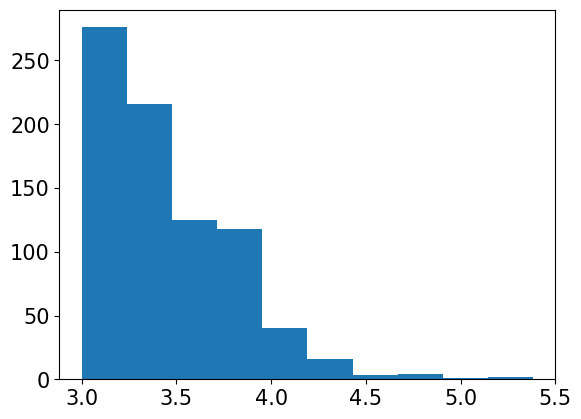

801


In [10]:
plt.hist(np.log10([d['length'] for d in ground_truth]))
plt.show()

print(len([d for d in ground_truth if d['length']>1000]))

In [11]:
# check overlap

chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(deletions):
    chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))
gt_chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(ground_truth):
    gt_chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))

del_to_overlaps = defaultdict(list)
gt_del_to_overlaps = defaultdict(list)

all_deletions = []
is_used = np.zeros((len(deletions),), dtype=bool)
gt_is_used = np.zeros((len(ground_truth),), dtype=bool)

for (fam, chrom), ds in chrom_fam_to_dels.items():
    sds = gt_chrom_fam_to_dels[(fam, chrom)]

    for i, d in ds:
        d_start, d_end = d['start_pos'], d['end_pos']
        for j, sb in sds:
            if (d['chrom']==sb['chrom']) and (d['child']==sb['child']):
                overlap = max(0, min(d_end, sb['end_pos']) - max(d_start, sb['start_pos']))
                wide_overlap = min(d['opt_end_pos'], sb['end_pos']) - max(d['opt_start_pos'], sb['start_pos'])
                
                if (overlap/d['length']>0.5) and (wide_overlap/sb['length']>0.5):
                    all_deletions.append((d, sb))
                    is_used[i] = True
                    gt_is_used[j] = True
for i in np.where(~is_used)[0]:
    all_deletions.append((deletions[i], None))
for j in np.where(~gt_is_used)[0]:
    all_deletions.append((None, ground_truth[j]))


print(len([d for d in all_deletions if d[0] is not None and d[1] is not None]),
     len([d for d in all_deletions if d[0] is not None and d[1] is None]),
     len([d for d in all_deletions if d[0] is None and d[1] is not None]))

51 42 750


In [12]:
chrom_to_ok_region_starts = defaultdict(list)
chrom_to_ok_region_ends = defaultdict(list)

with open('../data/hg002/HG002_SVs_Tier1_v0.6.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chrom_to_ok_region_starts[pieces[0]].append(int(pieces[1])+1)
        chrom_to_ok_region_ends[pieces[0]].append(int(pieces[2]))

for chrom in chrom_to_ok_region_starts.keys():
    chrom_to_ok_region_starts[chrom] = np.array(chrom_to_ok_region_starts[chrom])
    chrom_to_ok_region_ends[chrom] = np.array(chrom_to_ok_region_ends[chrom])
        
is_ok = np.ones((len(all_deletions),), dtype=bool)
for i, (d, gt) in enumerate(all_deletions):  
    starts = chrom_to_ok_region_starts[gt['chrom'] if gt is not None else d['chrom']]
    ends = chrom_to_ok_region_ends[gt['chrom'] if gt is not None else d['chrom']]
    
    if gt is not None:
        start_ok = np.any((starts <= gt['start_pos']) & (gt['start_pos'] <= ends))
        end_ok = np.any((starts <= gt['end_pos']) & (gt['end_pos'] <= ends))
    else:
    
        start_overlaps = np.clip(np.minimum(d['start_pos'], ends) - np.maximum(d['opt_start_pos'], starts), 0, None)
        start_ok = np.sum(start_overlaps) > 0
    
        end_overlaps = np.clip(np.minimum(d['opt_end_pos'], ends) - np.maximum(d['end_pos'], starts), 0, None)
        end_ok = np.sum(end_overlaps) > 0

    is_ok[i] = start_ok and end_ok
print(np.sum(is_ok)/len(is_ok))
  
discarded_deletions = [x for x, ok in zip(all_deletions, is_ok) if not ok]
all_deletions = [x for x, ok in zip(all_deletions, is_ok) if ok]
print(len(all_deletions))


0.631079478054567
532


([<matplotlib.axis.YTick at 0x7fa234ba0880>,
 [Text(0, 3.0, '$10^3$'),
  Text(0, 4.0, '$10^4$'),
  Text(0, 5.0, '$10^5$'),
  Text(0, 6.0, '$10^6$')])

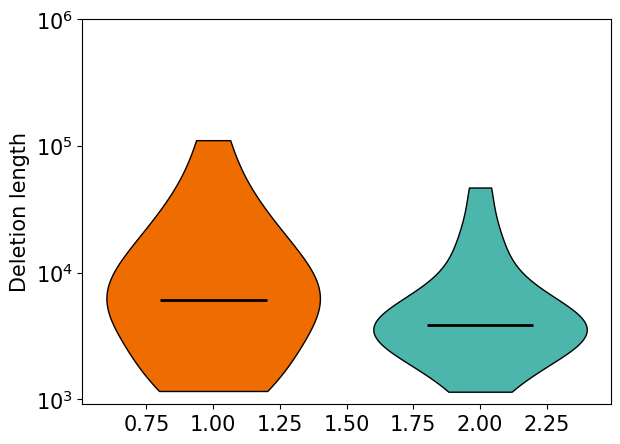

In [13]:
fig = plt.figure(figsize=(15, 5))

bins = np.arange(3, 5.5, 0.1)


ax = plt.subplot(1, 2, 1)
parts = plt.violinplot([np.log10([d[0]['length'] for d in all_deletions if d[0] is not None and d[0]['is_mat']]),
                np.log10([d[0]['length'] for d in all_deletions if d[0] is not None and d[0]['is_pat']])], 
                showmedians=True, showextrema=False, widths=0.8)
plt.ylabel('Deletion length')

parts['bodies'][0].set_facecolor(colors[0])
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)
parts['bodies'][1].set_facecolor(colors[1])
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

plt.yticks(np.log10([10**3, 10**4, 10**5, 10**6]), ['$10^3$', '$10^4$', '$10^5$', '$10^6$'])


In [14]:
print(np.sum([d[0]['length'] for d in all_deletions if d[0] is not None and d[0]['is_mat']]))
print(np.sum([d[0]['length'] for d in all_deletions if d[0] is not None and d[0]['is_pat']]))

343108
152747


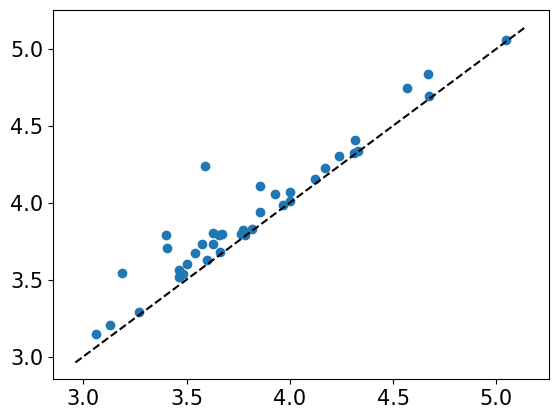

In [15]:
plt.scatter(np.log10([d[0]['length'] for d in all_deletions if d[0] is not None and d[1] is not None]),
           np.log10([d[1]['length'] for d in all_deletions if d[0] is not None and d[1] is not None]))
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()

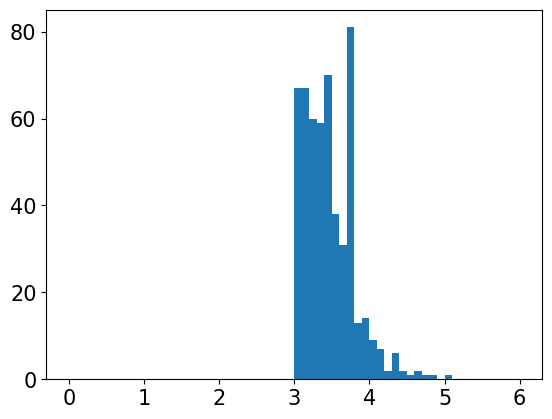

In [16]:
#print(lengths)
lengths = np.array([d[1]['length'] if (d[1] is not None) else d[0]['length'] for d in all_deletions])
plt.hist(np.log10(lengths), bins=np.arange(0, 6.1, 0.1))
plt.show()

In [17]:
print(np.sum([d[0]['length'] for d in all_deletions if d[0] is not None]))

495855


In [18]:
all_deletions = [x for x, l in zip(all_deletions, lengths) if l>1000]
lengths = np.array([d[1]['length'] if (d[1] is not None) else d[0]['length'] for d in all_deletions])


In [19]:
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
chrom_to_region_types = defaultdict(list)

with open('../data/filtered_regions_hg19.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1)
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            chrom_to_region_types[pieces[0][3:]].append(pieces[3])

#with open('../data/telomere37.bed', 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[0][3:] in chroms:
#            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1)
#            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
#            chrom_to_region_types[pieces[0][3:]].append('telomere')
#            
#            if int(pieces[1])==0:
#                chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[2])+1)
#                chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2])+1000000)
#                chrom_to_region_types[pieces[0][3:]].append('subtelomere')
#            else:
#                chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1-1000000)
#                chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[1]))
#                chrom_to_region_types[pieces[0][3:]].append('subtelomere')
            

region_type_mapping = {
    'SINE': 'SINE',
    'LINE': 'LINE',
    'DNA': 'DNA',
    'LTR': 'LTR',
    'Low_complexity': 'Low_complexity',
    'Simple_repeat': 'STR',
    'Satellite': 'Other',
     'Unknown': 'Other',
    'snRNA': 'Other',
    'tRNA': 'Other',
    'DNA?': 'Other',
    'srpRNA': 'Other',
    'rRNA': 'Other',
    'RC': 'Other',
    'Other': 'Other',
    'SINE?': 'Other',
    'scRNA': 'Other',
    'RNA': 'Other',
    'LTR?': 'Other',
    'Unknown?': 'Other',
    'LINE?': 'Other',
   
}

with open('../data/hg19.fa.out', 'r') as f:
    next(f) # skip header
    next(f) # skip header
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        chrom = pieces[4][3:]
        start_pos = int(pieces[5])
        end_pos = int(pieces[6])
        region_type = pieces[10].split('/')[0]
        
        chrom_to_interval_starts[chrom].append(start_pos)
        chrom_to_interval_ends[chrom].append(end_pos)
        chrom_to_region_types[chrom].append(region_type_mapping[region_type])
        



In [20]:
with open('../data/hg19.trf.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chrom = pieces[0][3:]
        start_pos = int(pieces[1])
        end_pos = int(pieces[2])
        
        chrom_to_interval_starts[chrom].append(start_pos)
        chrom_to_interval_ends[chrom].append(end_pos)
        chrom_to_region_types[chrom].append('TRF')
            
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
    print(Counter(chrom_to_region_types[chrom]))

Counter({'unmapable': 166668, 'SINE': 161838, 'LINE': 122076, 'LTR': 52338, 'DNA': 35183, 'TRF': 32524, 'STR': 31509, 'Low_complexity': 27226, 'Other': 2684, 'segDup': 604, 'centromere': 2})
Counter({'unmapable': 156181, 'SINE': 129092, 'LINE': 120533, 'LTR': 57510, 'DNA': 39451, 'STR': 33890, 'TRF': 32393, 'Low_complexity': 31272, 'Other': 2605, 'segDup': 443, 'abparts': 3, 'centromere': 2})
Counter({'unmapable': 131361, 'SINE': 109734, 'LINE': 101012, 'LTR': 48146, 'DNA': 34468, 'STR': 26439, 'Low_complexity': 26171, 'TRF': 25701, 'Other': 2064, 'segDup': 397, 'centromere': 2})
Counter({'unmapable': 132204, 'LINE': 93200, 'SINE': 88355, 'LTR': 53033, 'Low_complexity': 30911, 'DNA': 27475, 'STR': 26681, 'TRF': 24409, 'Other': 2041, 'segDup': 300, 'centromere': 2})
Counter({'unmapable': 119185, 'SINE': 92725, 'LINE': 89512, 'LTR': 45760, 'DNA': 28972, 'STR': 24668, 'Low_complexity': 24458, 'TRF': 23532, 'Other': 1779, 'segDup': 374, 'centromere': 2})
Counter({'unmapable': 114651, 'SINE

In [21]:
is_sine = np.zeros((len(all_deletions), ), dtype=bool)
is_line = np.zeros((len(all_deletions),), dtype=bool)
is_dna = np.zeros((len(all_deletions),), dtype=bool)
is_ltr = np.zeros((len(all_deletions),), dtype=bool)
is_str = np.zeros((len(all_deletions),), dtype=bool)
is_lc = np.zeros((len(all_deletions),), dtype=bool)
is_other = np.zeros((len(all_deletions),), dtype=bool)
is_trf = np.zeros((len(all_deletions),), dtype=bool)

is_cen = np.zeros((len(all_deletions),), dtype=bool)
is_unmap = np.zeros((len(all_deletions),), dtype=bool)
is_segdup = np.zeros((len(all_deletions),), dtype=bool)


for chrom in chroms:
    print(chrom, end=' ')
    starts, ends = chrom_to_interval_starts[chrom], chrom_to_interval_ends[chrom]
    region_types = chrom_to_region_types[chrom]
       
    for rt, data in [('SINE', is_sine), 
                     ('LINE', is_line), 
                     ('DNA', is_dna), 
                     ('LTR', is_ltr), 
                     ('STR', is_str),
                     ('Low_complexity', is_lc),
                     ('Other', is_other),
                     ('TRF', is_trf),
                     ('centromere', is_cen), 
                     ('unmapable', is_unmap), 
                     ('segDup', is_segdup), 
                            ]:
        print(rt, end=' ')
        is_rt = np.array([r==rt for r in region_types])
            
        for i, (d, gt) in [x for x in enumerate(all_deletions)]:
            ch = gt['chrom'] if gt is not None else d['chrom']
            start_pos = gt['start_pos'] if gt is not None else d['start_pos']
            end_pos = gt['end_pos'] if gt is not None else d['end_pos']
            
            if chrom == ch:
                overlaps = np.clip(np.minimum(end_pos, ends[is_rt]) - np.maximum(start_pos, starts[is_rt]), 0, None)
                data[i] = np.sum(overlaps) > 0
                
                

    print()
    
is_str_break = is_str | (is_trf & ~is_sine & ~is_line & ~is_dna & ~is_ltr & ~is_lc & ~is_other)
is_no_repeat = ~is_sine & ~is_line & ~is_dna & ~is_ltr & ~is_str & ~is_lc & ~is_other
print('SINE', np.sum(is_sine))
print('LINE', np.sum(is_line))
print('DNA', np.sum(is_dna))
print('LTR', np.sum(is_ltr))
print('STR', np.sum(is_str))
print('Low_complexity', np.sum(is_lc))
print('Other', np.sum(is_other))
print('No_repeat', np.sum(is_no_repeat))



1 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
2 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
3 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
4 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
5 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
6 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
7 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
8 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
9 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
10 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
11 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
12 SINE LINE DNA LTR STR Low_complexity Other TRF centromere unmapable segDup 
13 SINE LINE DNA LTR STR Low_complexity Other TRF centromere 

In [22]:
is_val = [x[0] is not None and x[1] is not None for x in all_deletions]


# compare

In [23]:
quality_score = np.array([0 if d[0] is None else d[0]['quality_score'] for d in all_deletions])
ytrue = np.array([x[1] is not None for x in all_deletions])

In [24]:
overall_recall = np.sum(ytrue & (quality_score>0))/np.sum(ytrue)
overall_precision = np.sum(ytrue & (quality_score>0))/np.sum(quality_score>0)

print(overall_precision, overall_recall)

0.8863636363636364 0.07400379506641366


In [25]:
def get_confint(x, n):
    val = x/n
    lb, ub = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    return val, ub, lb

# Repeats / SNVs within deletion

In [26]:
#breakpoint_variants_break = np.zeros((len(all_deletions),), dtype=int)
#breakpoint_variants_int = np.zeros((len(all_deletions),), dtype=int)
#for chrom in chroms:
#    
#    chrom_dels = [(i, x) for i, x in enumerate(all_deletions) if (x[0] is not None and x[0]['chrom']==chrom) or (x[1] is not None and x[1]['chrom']==chrom)]
#    print(chrom, len(chrom_dels))
#    
#    coords = np.load('../../DATA/hg002/genotypes/chr.%s.0.gen.coordinates.npy' % chrom)
#    pos = coords[:, 1]
#    is_snp = coords[:, 2]==1
#    is_pass = coords[:, 3]==1
#    
#    for i, (d, gt) in chrom_dels:
#        if gt is not None:
#            start_pos, end_pos = gt['start_pos'], gt['end_pos']
#            breakpoint_variants_break[i] = np.sum(is_pass[(start_pos-50 <= pos) & (pos <= start_pos+50)]) + \
#                                           np.sum(is_pass[(end_pos-50 <= pos) & (pos <= end_pos+50)])
#            
#        if d is not None:
#            breakpoint_variants_int[i] = np.median([np.sum(is_pass[(start_pos-50 <= pos) & (pos <= start_pos+50)]) for start_pos in range(d['opt_start_pos'], d['start_pos'])]) + \
#                                         np.median([np.sum(is_pass[(end_pos-50 <= pos) & (pos <= end_pos+50)]) for end_pos in range(d['end_pos'], d['opt_end_pos'])])#
#
#            #breakpoint_variants_int[i] = 100*np.sum(is_pass[(d['opt_start_pos']-50 <= pos) & (pos <= d['start_pos']+50)])/(d['start_pos']-d['opt_start_pos']) + \
#            #                             100*np.sum(is_pass[(d['end_pos']-50 <= pos) & (pos <= d['opt_end_pos']+50)])/(d['opt_end_pos']-d['end_pos'])
#            #start_pos, end_pos = (d['start_pos']+d['opt_start_pos'])/2, (d['end_pos']+d['opt_end_pos'])/2
#            #breakpoint_variants_int[i] = np.sum(is_pass[(start_pos-50 <= pos) & (pos <= start_pos+50)]) + \
#            #                               np.sum(is_pass[(end_pos-50 <= pos) & (pos <= end_pos+50)])
#            
#        
#    
#    print(coords.shape)

[ 0. 30.  2.] [ 0. 35.  2.] [ 0. 30.  2.] [  4. 393.  23.]


/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_25547/3604730298.py:2: RuntimeWarning: invalid value encountered in true_divide
  val = x/n
/Users/kelley/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/proportion.py:89: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


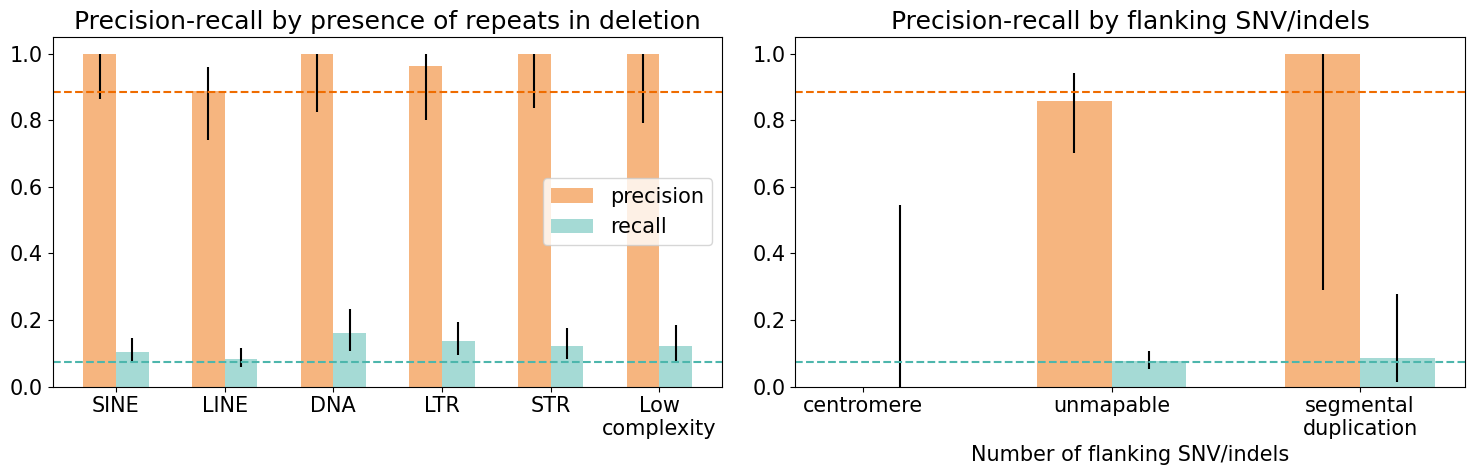

In [27]:
fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
precision_x, precision_n, recall_x, recall_n = np.zeros((6,)), np.zeros((6,)), np.zeros((6,)), np.zeros((6,))

for i, f in enumerate([
                       is_sine, 
                       is_line, 
                       is_dna, 
                       is_ltr, 
                       is_str, 
                       is_lc]):
    #print(np.sum(f), np.sum(quality_score[f]>0),
    #      np.sum(ytrue[f] & (quality_score[f]>0))/np.sum(ytrue[f]), 
    #      np.sum(ytrue[f] & (quality_score[f]>0))/np.sum(quality_score[f]>0))
    precision_x[i] = np.sum(ytrue[f] & (quality_score[f]>0))
    precision_n[i] = np.sum(quality_score[f]>0)
    recall_x[i] = np.sum(ytrue[f] & (quality_score[f]>0))
    recall_n[i] = np.sum(ytrue[f])
    
precision, precision_ub, precision_lb = get_confint(precision_x, precision_n)
recall, recall_ub, recall_lb = get_confint(recall_x, recall_n)


plt.bar(np.arange(6)-0.15, precision, yerr=(precision-precision_lb, precision_ub-precision), 
        width=0.3, alpha=0.5, label='precision', color=colors[0])
plt.bar(np.arange(6)+0.15, recall, yerr=(recall-recall_lb, recall_ub-recall), 
        width=0.3, alpha=0.5, label='recall', color=colors[1])   
plt.axhline(overall_precision, linestyle='--', color=colors[0])
plt.axhline(overall_recall, linestyle='--', color=colors[1])

plt.xticks(np.arange(6), ['SINE', 'LINE', 'DNA', 'LTR', 'STR', 'Low\ncomplexity'])
plt.title('Precision-recall by presence of repeats in deletion')
#plt.xlabel('Repeat Type')
plt.legend()
#plt.ylim(-0.1, 1.1)

plt.subplot(1, 2, 2, sharey=ax)

precision_x, precision_n, recall_x, recall_n = np.zeros((3,)), np.zeros((3,)), np.zeros((3,)), np.zeros((3,))

for i, f in enumerate([
                       is_cen, 
                       is_unmap, 
                       is_segdup, 
                       ]):
    #print(np.sum(f), np.sum(quality_score[f]>0),
    #      np.sum(ytrue[f] & (quality_score[f]>0))/np.sum(ytrue[f]), 
    #      np.sum(ytrue[f] & (quality_score[f]>0))/np.sum(quality_score[f]>0))
    precision_x[i] = np.sum(ytrue[f] & (quality_score[f]>0))
    precision_n[i] = np.sum(quality_score[f]>0)
    recall_x[i] = np.sum(ytrue[f] & (quality_score[f]>0))
    recall_n[i] = np.sum(ytrue[f])
    
precision, precision_ub, precision_lb = get_confint(precision_x, precision_n)
recall, recall_ub, recall_lb = get_confint(recall_x, recall_n)
print(precision_x, precision_n, recall_x, recall_n)

plt.bar(np.arange(3)-0.15, precision, yerr=(precision-precision_lb, precision_ub-precision), 
        width=0.3, alpha=0.5, label='precision', color=colors[0])
plt.bar(np.arange(3)+0.15, recall, yerr=(recall-recall_lb, recall_ub-recall), 
        width=0.3, alpha=0.5, label='recall', color=colors[1])

plt.axhline(overall_precision, linestyle='--', color=colors[0])
plt.axhline(overall_recall, linestyle='--', color=colors[1])

#plt.plot(np.arange(6), precision, label='precision')
#plt.fill_between(np.arange(6), precision_lb, precision_ub, alpha=0.1)
#plt.plot(np.arange(6), recall, label='recall')
#plt.fill_between(np.arange(6), recall_lb, recall_ub, alpha=0.1)

plt.xticks(np.arange(3), ['centromere', 'unmapable', 'segmental\nduplication'])
plt.title('Precision-recall by flanking SNV/indels')
#plt.legend()
plt.xlabel('Number of flanking SNV/indels')
#plt.ylim(None, 1.1)

#plt.show()
plt.tight_layout()
fig.savefig('../plots/hard-to-sequence.png', dpi=fig.dpi)



In [28]:
print([all_deletions[i] for i in np.where(is_cen)[0]])

[(None, {'family': 'hg002', 'child': 'hg002', 'chrom': '5', 'start_pos': 46270652, 'end_pos': 46275836, 'length': 5184, 'opt_start_pos': 46270652, 'opt_end_pos': 46275836, 'mom_gt': '0/1', 'dad_gt': '1/1', 'child_gt': '1/1', 'mother': 'hg004', 'father': 'hg003', 'is_inherited': True, 'is_denovo': False, 'quality_score': None, 'line': '5\t46270652\tHG2_PB_pbsv_5780\tCTTCTCAAAAGAAGACATTCATGGAACCAAAAGAAGCATGAAAAATGCTCTTCATCACTGGCCATCAGAGAAATGCAAATCAAAACCACAATGAGATAACTTCTCACACCTGTTAGAATGGCGATCATTAAAAAGTCAGGAAACAACAGGTGCTGGAGAGGATGTGGAGAAATAGGAACACTTTTACACTTTTGAAGAGACTGTAAACTAGTTCAACCTTTGTGGAAGTCGGTGTGCCAATTCTTCAGGGATCAGAACTAGAAATACCACTTGACCCAGCCATCCCATTAGTGGGTATATACCCAAAGGATTATAAGTCATGCTGCTGTAAAGACACATGCACACGTATGTGTATTGTGCCACTATTCACAGCAGCAAAGACTTGGTACCAACCCAAATATCCAACAATTGTAGACTGCATTAAGAAAGTGTGGCACATATATACACCTTGGAATAATATGCAGACATAAAAAACGATGAATTCATGTCCTTTGTAGGGACATCGATGAAGCTGGAAACCATCATTCTCAGCAAACTATCACAAGGAGAAAAAACCAAACACTGCATGTTCTCACTCATAAGCGGGAATTGAACAGTGAGAACACATGGACACAGGGAGGGGAACATCACAC

# Precision/Recall as a function of deletion length and SNVs within deletion

In [29]:
internal_variants = np.zeros((len(all_deletions),), dtype=int)
for chrom in chroms:
    
    chrom_dels = [(i, x) for i, x in enumerate(all_deletions) if (x[0] is not None and x[0]['chrom']==chrom) or (x[1] is not None and x[1]['chrom']==chrom)]
    print(chrom, len(chrom_dels))
    
    coords = np.load('../../DATA/hg002/genotypes/chr.%s.0.gen.coordinates.npy' % chrom)
    pos = coords[:, 1]
    is_snp = coords[:, 2]==1
    is_pass = coords[:, 3]==1
    
    
    #gen = sparse.load_npz('../../DATA/hg002/genotypes/chr.%s.0.gen.npz' % chrom).A
    #is_hom = np.all(gen==0, axis=0) | np.all(gen==2, axis=0)

    for i, (d, gt) in chrom_dels:
        start_pos = gt['start_pos'] if gt is not None else (d['opt_start_pos']+d['start_pos'])/2
        end_pos = gt['end_pos'] if gt is not None else (d['opt_end_pos']+d['end_pos'])/2
        
        internal_variants[i] = np.sum((is_snp & is_pass)[(start_pos <= pos) & (pos <= end_pos)])
    
    print(coords.shape)

1 43
(512689, 4)
2 45
(512066, 4)
3 38
(432550, 4)
4 53
(456939, 4)
5 34
(395902, 4)
6 36
(404521, 4)
7 27
(370245, 4)
8 25
(342624, 4)
9 23
(293137, 4)
10 23
(321959, 4)
11 27
(314117, 4)
12 27
(300916, 4)
13 18
(232670, 4)
14 15
(212842, 4)
15 12
(198020, 4)
16 8
(200132, 4)
17 14
(180078, 4)
18 12
(178471, 4)
19 23
(150813, 4)
20 12
(134870, 4)
21 7
(107299, 4)
22 10
(67168, 4)


[0.88636364 0.88636364 0.90697674 0.92857143 0.92682927 0.925
 0.94871795 0.94736842 0.97297297 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
[0.0740038  0.08125    0.08944954 0.09263658 0.09620253 0.09390863
 0.10818713 0.11464968 0.15       0.18       0.18421053 0.18378378
 0.18232044 0.18823529 0.19496855 0.2027027  0.2        0.20289855
 0.21774194 0.21138211 0.36231884 0.35820896 0.34848485 0.34920635
 0.33870968 0.33898305 0.33333333 0.34615385 0.44736842 0.47058824
 0.48387097 0.53846154 0.52       0.52173913 0.64705882 0.625
 0.6        0.57142857 0.58333333 0.6        0.625      1.
 1.         1.         1.        ]
[ 11345  11650  12852  14243  16793  17216  20102  21156  

/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_25547/4007251107.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(thresholds), precision, label='precision', color=colors[0])
/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_25547/4007251107.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(np.log10(thresholds), precision_ub, precision_lb, alpha=0.25, color=colors[0])
/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_25547/4007251107.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(thresholds), recall, label='recall', color=colors[1])
/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_25547/4007251107.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(np.log10(thresholds), recall_ub, recall_lb, alpha=0.25, color=colors[1])


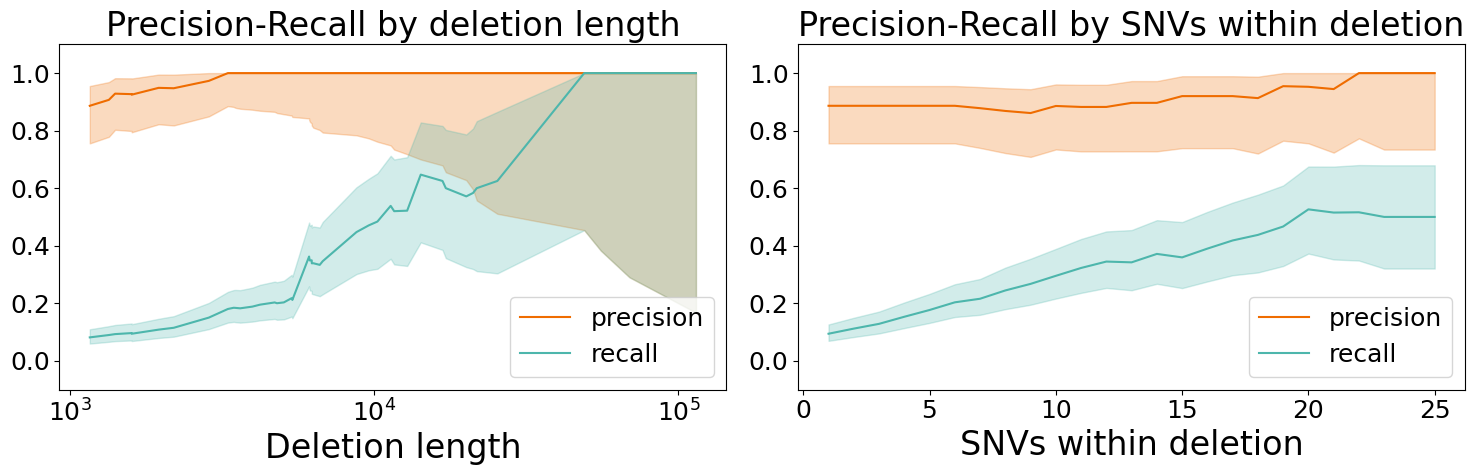

In [30]:
fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)

precision, recall, thresholds = precision_recall_curve(ytrue, lengths * (quality_score>0))
x, precision_n, recall_n = np.zeros((len(thresholds),)), np.zeros((len(thresholds),)), np.zeros((len(thresholds),))
for i, t in enumerate(thresholds):  
    x[i] = np.sum((quality_score[lengths>=t]>0) & ytrue[lengths>=t])
    recall_n[i] = np.sum(ytrue[lengths>=t])
    precision_n[i] = np.sum(quality_score[lengths>=t]>0)

precision, precision_ub, precision_lb = get_confint(x, precision_n)
recall, recall_ub, recall_lb = get_confint(x, recall_n)
print(precision)
print(recall)
print(thresholds[recall>=0.5])
print(thresholds[recall==1.0])

plt.plot(np.log10(thresholds), precision, label='precision', color=colors[0])
plt.fill_between(np.log10(thresholds), precision_ub, precision_lb, alpha=0.25, color=colors[0])
plt.plot(np.log10(thresholds), recall, label='recall', color=colors[1])
plt.fill_between(np.log10(thresholds), recall_ub, recall_lb, alpha=0.25, color=colors[1])
plt.xticks(np.arange(3, 6), ['$10^{%d}$' % i for i in np.arange(3, 6)], fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Deletion length', fontsize=24)
plt.legend(fontsize=18)
plt.title('Precision-Recall by deletion length', fontsize=24)

plt.subplot(1, 2, 2, sharey=ax)

x, precision_n, recall_n = np.zeros((26,)), np.zeros((26,)), np.zeros((26,))
for i in range(26):  
    x[i] = np.sum((quality_score[internal_variants>=i]>0) & ytrue[internal_variants>=i])
    recall_n[i] = np.sum(ytrue[internal_variants>=i])
    precision_n[i] = np.sum(quality_score[internal_variants>=i]>0)

precision, precision_ub, precision_lb = get_confint(x, precision_n)
recall, recall_ub, recall_lb = get_confint(x, recall_n)
print(precision)
print(recall)
print(np.arange(26)[recall>=0.5])

plt.plot(np.arange(1, 26), precision[1:], label='precision', color=colors[0])
plt.fill_between(np.arange(1, 26), precision_ub[1:], precision_lb[1:], alpha=0.25, color=colors[0])
plt.plot(np.arange(1, 26), recall[1:], label='recall', color=colors[1])
plt.fill_between(np.arange(1, 26), recall_ub[1:], recall_lb[1:], alpha=0.25, color=colors[1])
#plt.xticks(np.arange(25))
plt.xlabel('SNVs within deletion', fontsize=24)
plt.legend(fontsize=18)
plt.ylim([-0.1, 1.1])
plt.title('Precision-Recall by SNVs within deletion', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
#plt.show()
fig.savefig('../plots/dellength_snvs.png', dpi=fig.dpi)
fig.savefig('../plots/Fig_8.png', dpi=fig.dpi)


# Take a look at a region up close

In [680]:
#chrom, start_pos, end_pos = '14', 106270403, 106322561
chrom, start_pos, end_pos = '19', 35662174-10000, 35665664+10000

gt_detail = -np.ones((end_pos-start_pos, 3), dtype=int)
del_detail = -np.ones((end_pos-start_pos, 3), dtype=int)

gtcode = {'./.': 3, '0/0': 0, '0/1': 1, '1/1': 2, './1': 1}

with gzip.open('../data/hg002/HG002_SVs_Tier1_v0.6.vcf.gz', 'rt') as f:
    line = next(f)
    while line.startswith('#'):
        print(line)
        line = next(f)
        
    for line in f:
        if 'SVTYPE=DEL' in line:
            # is deletion
            pieces = line.strip().split('\t')
            if pieces[0]==chrom and pieces[6]=='PASS':
                s = int(pieces[1])
                e = [int(x[4:]) for x in info if x.startswith('END=')][0]
                
                gt = pieces[9][:3]
                if (min(end_pos, e)-max(start_pos, s)>0) and (gt=='0/1' or gt=='1/1'):
                    print(line)
                    dad = [x[9:] for x in info if x.startswith('HG003_GT=')][0]
                    mom = [x[9:] for x in info if x.startswith('HG004_GT=')][0]
                    
                    gt_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 0] = gtcode[gt]
                    gt_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 1] = gtcode[mom]
                    gt_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 2] = gtcode[dad]
                    
with open('%s/deletions.json' % phase_dir) as f:
    for d in json.load(f):
        if d['is_inherited'] and d['chrom']==chrom and min(end_pos, d['end_pos'])-max(start_pos, d['start_pos'])>0:
            s, e = d['start_pos'], d['end_pos']
            gt = '0/1'
            mom = '0/1' if d['is_mat'] else '0/0'
            dad = '0/1' if d['is_pat'] else '0/0'
            del_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 0] = gtcode[gt]
            del_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 1] = gtcode[mom]
            del_detail[max(0, s-start_pos):min(end_pos-start_pos, e-start_pos), 2] = gtcode[dad]    


##fileformat=VCFv4.2

##fileDate=20180605

##reference=GRCh37

##contig=<ID=1,length=249250621>

##contig=<ID=2,length=243199373>

##contig=<ID=3,length=198022430>

##contig=<ID=4,length=191154276>

##contig=<ID=5,length=180915260>

##contig=<ID=6,length=171115067>

##contig=<ID=7,length=159138663>

##contig=<ID=8,length=146364022>

##contig=<ID=9,length=141213431>

##contig=<ID=10,length=135534747>

##contig=<ID=11,length=135006516>

##contig=<ID=12,length=133851895>

##contig=<ID=13,length=115169878>

##contig=<ID=14,length=107349540>

##contig=<ID=15,length=102531392>

##contig=<ID=16,length=90354753>

##contig=<ID=17,length=81195210>

##contig=<ID=18,length=78077248>

##contig=<ID=19,length=59128983>

##contig=<ID=20,length=63025520>

##contig=<ID=21,length=48129895>

##contig=<ID=22,length=51304566>

##contig=<ID=X,length=155270560>

##contig=<ID=Y,length=59373566>

##contig=<ID=MT,length=16569>

##FILTER=<ID=NoConsensusGT,Description="No individual had genotypes from svviz agree 

19	404476	HG2_PB_SVrefine2Falcon1plusDovetail_5428	TGGGGGGGGCACGGGGTCCTGCCCTGAGGGGTGTGGGGGGGACGGGGTCCTGCCCTGAGGGGTGTGGGGGGGACGGGGTCCTGCCCTGAGGGGTGTG	T	10	PASS	ClusterIDs=HG3_PB_pbsv_17416:HG2_PB_assemblyticsfalcon_12007:HG2_PB_SVrefine2PB10Xhap12_12890:HG2_PB_SVrefine2Falcon1plusDovetail_5428:HG4_PB_pbsv_17639:HG2_PB_pbsv_17724:HG2_PB_HySA_32215;NumClusterSVs=7;ExactMatchIDs=HG2_PB_SVrefine2Falcon1plusDovetail_5428:HG2_PB_SVrefine2PB10Xhap12_12890;NumExactMatchSVs=2;ClusterMaxShiftDist=0.0717948717948718;ClusterMaxSizeDiff=0.0717948717948718;ClusterMaxEditDist=0.145833333333333;PBcalls=7;Illcalls=0;TenXcalls=0;CGcalls=0;PBexactcalls=2;Illexactcalls=0;TenXexactcalls=0;CGexactcalls=0;HG2count=5;HG3count=1;HG4count=1;NumTechs=1;NumTechsExact=1;SVLEN=-96;DistBack=129;DistForward=-88;DistMin=-88;DistMinlt1000=TRUE;MultiTech=FALSE;MultiTechExact=FALSE;SVTYPE=DEL;END=404572;sizecat=50to99;DistPASSHG2gt49Minlt1000=FALSE;DistPASSMinlt1000=FALSE;MendelianError=FALSE;HG003_GT=./.;HG004_GT=./.;TRa

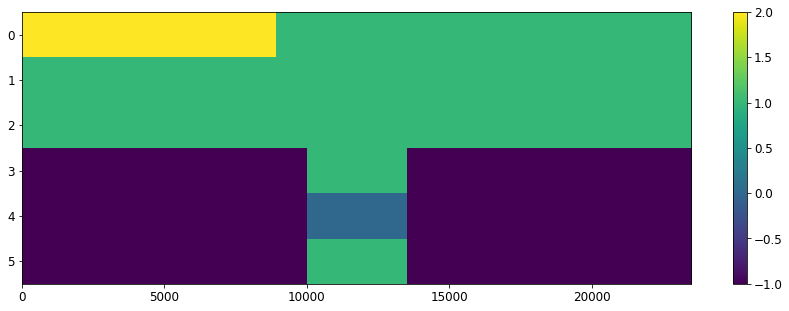

In [681]:
plt.figure(figsize=(15, 5))
plt.imshow(np.vstack((gt_detail.T, del_detail.T)), aspect='auto')
plt.colorbar()
plt.show()